In [1]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2024-03-23 16:05:20
# @Last Modified: 2024-03-23 16:05:38
# ------------------------------------------------------------------------------ #
# Here we run the bayesian analysis.
# Final plotting is done in a different notebook, as the analysis takes quite
# some time.
# ------------------------------------------------------------------------------ #

%load_ext autoreload
%autoreload 2

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("../dat/")


2025-01-28 17:32:12,167 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/explore_layers_carlos/experiment_analysis


In [ ]:

# load our results from timescale fitting
df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
df = utl.load_metrics(
    df.reset_index(),
    data_dir,
    csvs=[
        # we need to combine data from different files, because we use spontaneous and natural movie stimuli
        "brain_observatory_1.1_analysis_metrics.csv",
        "functional_connectivity_analysis_metrics.csv",
    ],
    cols=["on_screen_rf"],
)
df = utl.add_structure_and_hierarchy_scores(df)
df = utl.load_experiments(df, data_dir)

# pymc does not like bools:
log.info(f'invalid metric rows: {df["on_screen_rf"].isna().sum()}')
df["on_screen_rf"] = df["on_screen_rf"].astype("int")

len_before = len(df)
df = df.query("tau_R > 0.0")
df = df.query("tau_double > 0.0 & tau_double < 10.0")

# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

# some further preprocessing is done in the model class
# see ana/bayesian_models.py
df.head()

2025-01-28 17:37:33,208 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/explore_layers_carlos/experiment_analysis/dat/brain_observatory_1.1_analysis_metrics.csv
2025-01-28 17:37:33,500 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/explore_layers_carlos/experiment_analysis/dat/functional_connectivity_analysis_metrics.csv
2025-01-28 17:37:33,501 | INFO     | its_utility | load_metrics | Column on_screen_rf found in multiple dataframes.
2025-01-28 17:37:33,503 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/explore_layers_carlos/experiment_analysis/dat/brain_observatory_1.1_analysis_metrics.csv
2025-01-28 17:37:38,185 | DEBUG    | its_utility | load_metrics | Matched 11581 rows from meta_

unit_id             stimulus    session               block  \
0  950911932  natural_movie_three  715093703  merged_3.0_and_6.0   
1  950911986  natural_movie_three  715093703  merged_3.0_and_6.0   
2  950912164  natural_movie_three  715093703  merged_3.0_and_6.0   
3  950912190  natural_movie_three  715093703  merged_3.0_and_6.0   
4  950912214  natural_movie_three  715093703  merged_3.0_and_6.0   

  ecephys_structure_acronym invalid_spiketimes_check  recording_length  \
0                     VISam                  SUCCESS       1078.491211   
1                     VISam                  SUCCESS       1079.203369   
2                     VISam                  SUCCESS       1077.872803   
3                     VISam                  SUCCESS       1075.171875   
4                     VISam                  SUCCESS       1073.492432   

   firing_rate                                           filepath  num_spikes  \
0     8.025100  /project.nst/neuroscience-raw/Allen/visual_cod...        8655   
1     3.647135  /project.nst/neuroscience-raw/Allen/visual_cod...        3936   
2     8.500075  /project.nst/neuroscience-raw/Allen/visual_cod...        9162   
3     4.399297  /project.nst/neuroscience-raw/Allen/visual_cod...        4730   
4     5.326540  /project.nst/neuroscience-raw/Allen/visual_cod...        5718   

   ...     tau_R  tau_single  tau_double  \
0  ...  0.058510    0.000054    0.748946   
1  ...  0.088701    2.302634    1.874703   
2  ...  0.059416    1.026283    1.026284   
3  ...  0.116100    1.564297    1.363502   
4  ...  0.064748    0.605686    0.377801   

                                       tau_R_details  \
0  {'firing_rate': 8.012090922999178, 'firing_rat...   
1  {'firing_rate': 3.6471291367256455, 'firing_ra...   
2  {'firing_rate': 8.475008697669026, 'firing_rat...   
3  {'firing_rate': 4.395563512916502, 'firing_rat...   
4  {'firing_rate': 5.317211538013684, 'firing_rat...   

                                  tau_single_details  \
0  {'tau': 5.404084198337884e-05, 'mre': 6.575654...   
1  {'tau': 2.3026338728859774, 'mre': 0.997830929...   
2  {'tau': 1.0262833654998276, 'mre': 0.995139899...   
3  {'tau': 1.5642971952849982, 'mre': 0.996808779...   
4  {'tau': 0.6056864214354767, 'mre': 0.991778883...   

                                  tau_double_details on_screen_rf  \
0  {'tau': 0.7489462162647652, 'mre': 0.993346188...            0   
1  {'tau': 1.874703126979266, 'mre': 0.9973364645...            0   
2  {'tau': 1.0262836602024297, 'mre': 0.995139901...            1   
3  {'tau': 1.363502294341311, 'mre': 0.9963396881...            1   
4  {'tau': 0.37780093267583975, 'mre': 0.98685270...            1   

  structure_name  hierarchy_score           session_type  
0             AM            0.441  brain_observatory_1.1  
1             AM            0.441  brain_observatory_1.1  
2             AM            0.441  brain_observatory_1.1  
3             AM            0.441  brain_observatory_1.1  
4             AM            0.441  brain_observatory_1.1  

[5 rows x 22 columns]

            mu_intercept ~ Normal(0, 1)
         sigma_intercept ~ HalfCauchy(0, 1)
                mu_slope ~ Normal(0, 1)
             sigma_slope ~ HalfCauchy(0, 1)
session_intercept_scaled ~ Normal(0, 1)
    session_slope_scaled ~ Normal(0, 1)
                 b_os_rf ~ Normal(0, 1)
                b_log_fr ~ Normal(0, 1)
                 epsilon ~ HalfCauchy(0, 10)
                   alpha ~ Normal(0, 1)
       session_intercept ~ Deterministic(f(session_intercept_scaled, mu_intercept, sigma_intercept))
           session_slope ~ Deterministic(f(session_slope_scaled, mu_slope, sigma_slope))
              likelihood ~ SkewNormal(f(b_log_fr, b_os_rf, session_intercept_scaled, mu_intercept, session_slope_scaled, mu_slope, sigma_intercept, sigma_slope), epsilon, alpha)


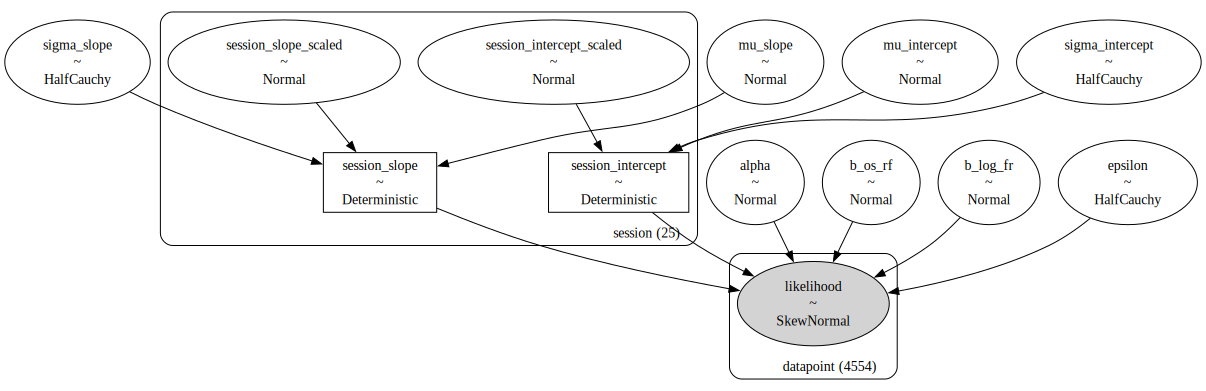

In [8]:
lm_tau_R = bm.LinearMedianModel(
    df=df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ),
    measure="tau_R",
    noncentered=True,
)
print(lm_tau_R.str_repr())
pm.model_to_graphviz(lm_tau_R)

     mu_intercept ~ Normal(0, 1)
  sigma_intercept ~ HalfCauchy(0, 0.1)
     mu_hc_offset ~ Normal(0, 1)
  sigma_hc_offset ~ HalfCauchy(0, 1)
     mu_th_offset ~ Normal(0, 1)
  sigma_th_offset ~ HalfCauchy(0, 1)
session_intercept ~ Normal(mu_intercept, sigma_intercept)
session_hc_offset ~ Normal(mu_hc_offset, sigma_hc_offset)
session_th_offset ~ Normal(mu_th_offset, sigma_th_offset)
          b_os_rf ~ Normal(0, 1)
         b_log_fr ~ Normal(0, 1)
          epsilon ~ HalfCauchy(0, 10)
       likelihood ~ Normal(f(b_log_fr, b_os_rf, session_th_offset, session_intercept, session_hc_offset), epsilon)


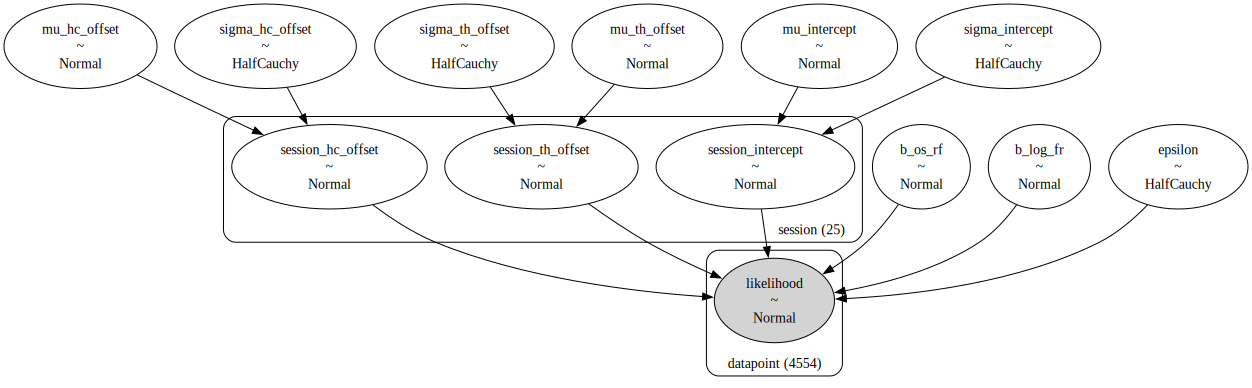

In [6]:
sgm_R_tot = bm.StructureGroupModel(
    df=df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ),
    measure="R_tot",
    noncentered=False,
)
print(sgm_R_tot.str_repr())
pm.model_to_graphviz(sgm_R_tot)

# Example analysis for linear model and measure `R_tot`

In [9]:
# sgm_tau_R = bm.StructureGroupModel(
#     df=df.query(
#         "stimulus == 'natural_movie_one_more_repeats'  & "
#         + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
#     ),
#     measure="tau_R",
#     noncentered=True,
# )
with lm_tau_R:
    idata = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=2000,
        random_seed=42,
        target_accept=0.95,
    )

In [10]:
with lm_tau_R:
    pm.compute_log_likelihood(idata)
    az.loo(idata, pointwise=True)

Output()

In [11]:
az.loo(idata, pointwise=True)

Computed from 12000 posterior samples and 4554 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6109.97    66.21
p_loo       39.83        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4554  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [12]:
with lm_tau_R:
    idata.extend(pm.sample_prior_predictive(random_seed=42))
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=42))

Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept_scaled, session_slope_scaled, sigma_intercept, sigma_slope]
2025-01-28 17:46:27,187 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept_scaled, session_slope_scaled, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2025-01-28 17:46:27,534 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

In [13]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [14]:
az.summary(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
        "session_slope",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
b_log_fr          -0.323  0.029  -0.378   -0.270      0.000    0.000   
b_os_rf           -0.200  0.027  -0.251   -0.148      0.000    0.000   
epsilon            1.340  0.022   1.298    1.382      0.000    0.000   
mu_intercept       2.441  0.123   2.211    2.676      0.002    0.001   
mu_slope           0.710  0.125   0.481    0.950      0.001    0.001   
sigma_intercept    0.416  0.086   0.262    0.574      0.001    0.001   
sigma_slope        0.471  0.114   0.268    0.688      0.002    0.001   
session_slope[0]   0.632  0.309   0.026    1.196      0.002    0.002   
session_slope[1]   0.906  0.274   0.410    1.433      0.002    0.002   
session_slope[2]   0.539  0.295  -0.019    1.084      0.002    0.002   
session_slope[3]   0.764  0.252   0.295    1.248      0.002    0.001   
session_slope[4]   1.063  0.352   0.417    1.734      0.003    0.002   
session_slope[5]   1.071  0.334   0.455    1.701      0.003    0.002   
session_slope[6]   0.675  0.236   0.221    1.109      0.002    0.001   
session_slope[7]   0.607  0.323   0.022    1.239      0.003    0.002   
session_slope[8]   1.289  0.263   0.793    1.785      0.002    0.001   
session_slope[9]   0.658  0.264   0.179    1.173      0.002    0.001   
session_slope[10]  0.721  0.229   0.312    1.164      0.002    0.001   
session_slope[11]  0.898  0.311   0.335    1.490      0.002    0.002   
session_slope[12]  0.642  0.383  -0.063    1.372      0.003    0.002   
session_slope[13]  0.204  0.155  -0.086    0.491      0.001    0.001   
session_slope[14] -0.079  0.246  -0.545    0.376      0.002    0.002   
session_slope[15]  0.849  0.337   0.248    1.519      0.003    0.002   
session_slope[16]  0.564  0.289   0.031    1.110      0.002    0.002   
session_slope[17]  0.701  0.299   0.136    1.270      0.002    0.002   
session_slope[18]  0.569  0.261   0.090    1.072      0.002    0.001   
session_slope[19]  0.951  0.264   0.458    1.451      0.002    0.001   
session_slope[20] -0.124  0.384  -0.838    0.598      0.004    0.003   
session_slope[21]  0.514  0.248   0.039    0.970      0.002    0.001   
session_slope[22]  0.838  0.306   0.256    1.403      0.002    0.002   
session_slope[23]  1.267  0.362   0.577    1.921      0.003    0.002   
session_slope[24]  1.185  0.316   0.591    1.766      0.003    0.002   

                   ess_bulk  ess_tail  r_hat  
b_log_fr            26247.0    8221.0    1.0  
b_os_rf             21739.0    8774.0    1.0  
epsilon             10922.0    9318.0    1.0  
mu_intercept         5193.0    6655.0    1.0  
mu_slope             6993.0    8121.0    1.0  
sigma_intercept      4921.0    6997.0    1.0  
sigma_slope          5341.0    6656.0    1.0  
session_slope[0]    18360.0    9997.0    1.0  
session_slope[1]    18246.0    9601.0    1.0  
session_slope[2]    18405.0   10109.0    1.0  
session_slope[3]    15546.0    9512.0    1.0  
session_slope[4]    16411.0    9814.0    1.0  
session_slope[5]    16372.0   10105.0    1.0  
session_slope[6]    16951.0   10076.0    1.0  
session_slope[7]    15713.0    8460.0    1.0  
session_slope[8]    16713.0    9169.0    1.0  
session_slope[9]    18706.0    9650.0    1.0  
session_slope[10]   15282.0    9966.0    1.0  
session_slope[11]   19888.0   10130.0    1.0  
session_slope[12]   17887.0    9696.0    1.0  
session_slope[13]   18191.0   10201.0    1.0  
session_slope[14]   12245.0    8317.0    1.0  
session_slope[15]   15520.0    8926.0    1.0  
session_slope[16]   14723.0    9342.0    1.0  
session_slope[17]   16774.0    9268.0    1.0  
session_slope[18]   17727.0    9975.0    1.0  
session_slope[19]   17793.0   10243.0    1.0  
session_slope[20]    9909.0    9113.0    1.0  
session_slope[21]   18851.0   10448.0    1.0  
session_slope[22]   18200.0   10326.0    1.0  
session_slope[23]   13756.0    9711.0    1.0  
session_slope[24]   14569.0    9187.0    1.0

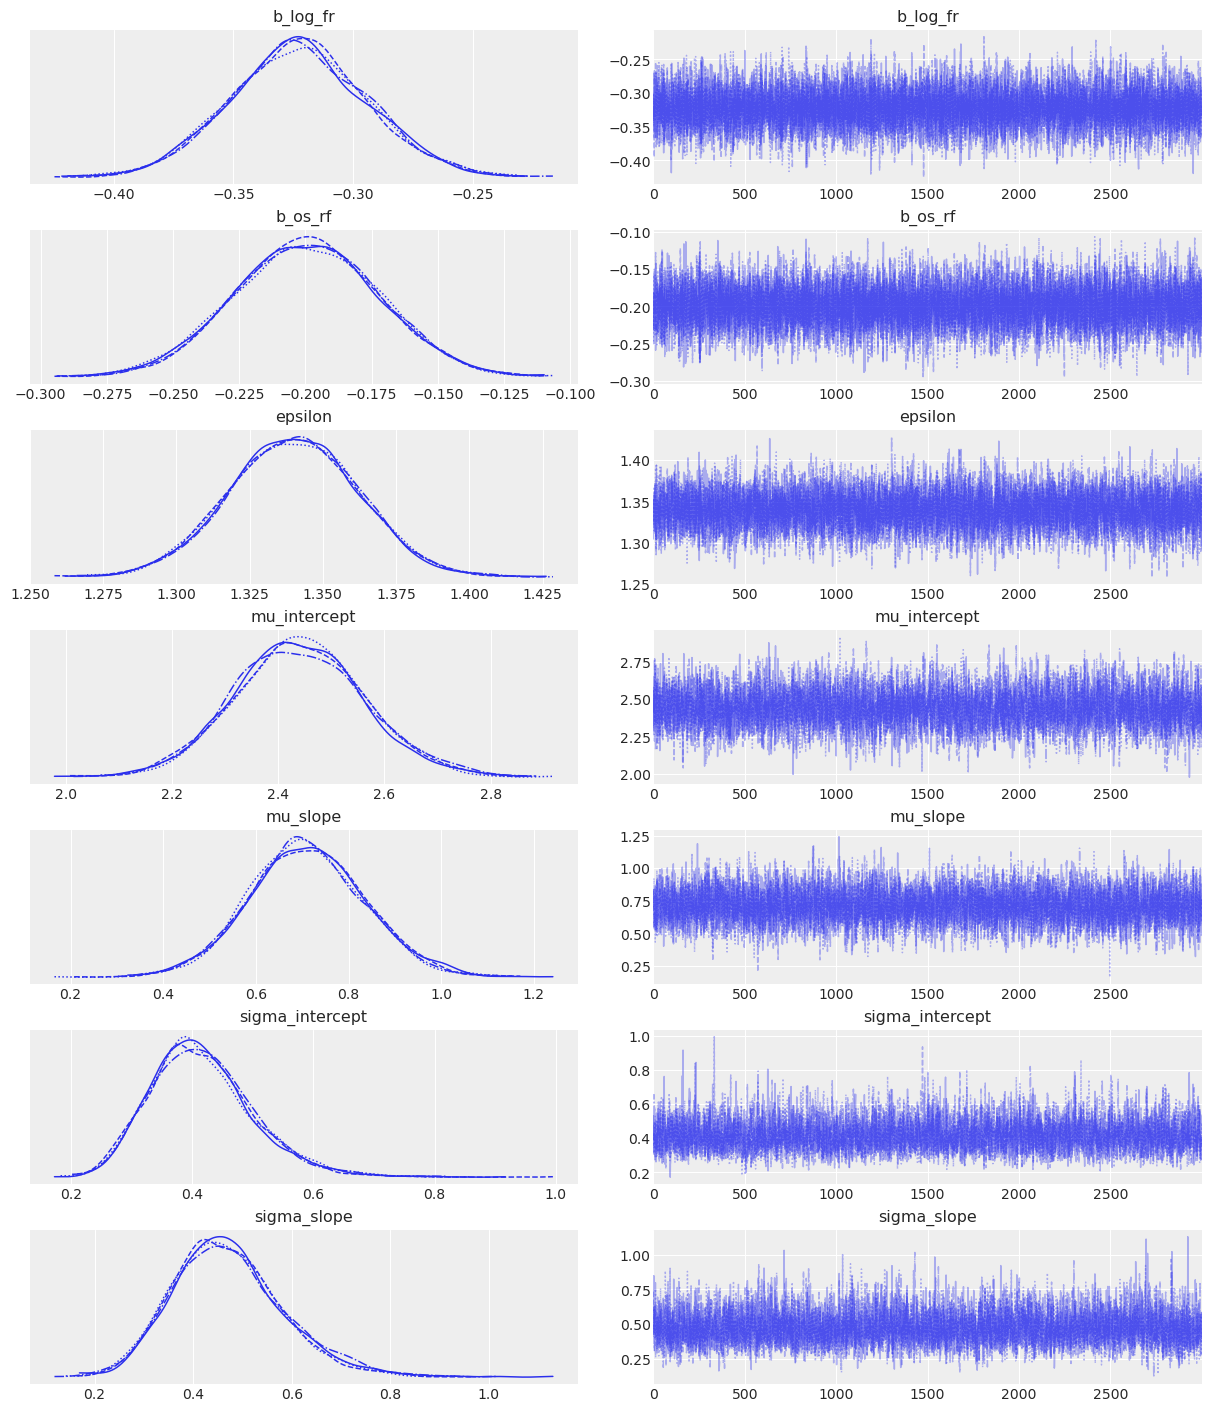

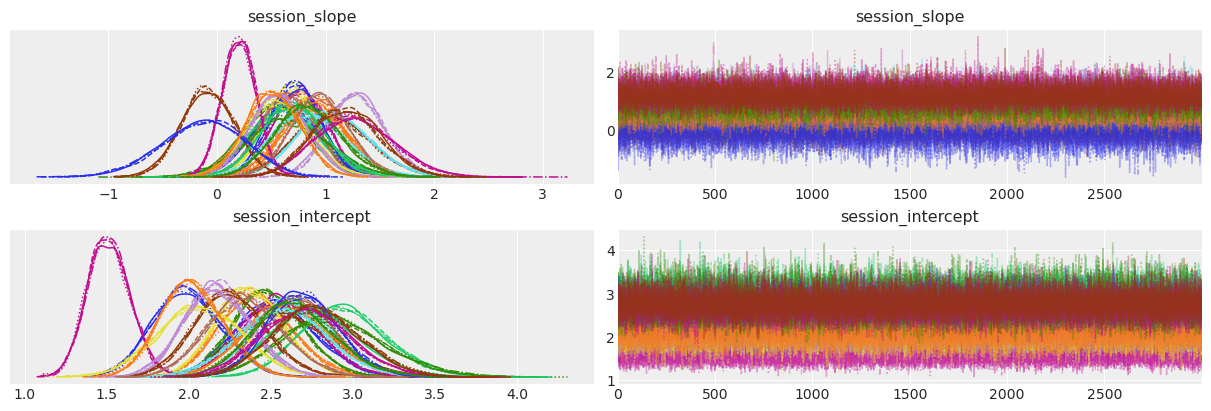

In [15]:
az.style.use("arviz-darkgrid")
# blue lines represent chains
az.plot_trace(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
    ],
    legend=False,
);
# color varies across sessions
az.plot_trace(
    idata,
    var_names=[
        "session_slope",
        "session_intercept",
    ],
    legend=False,
);

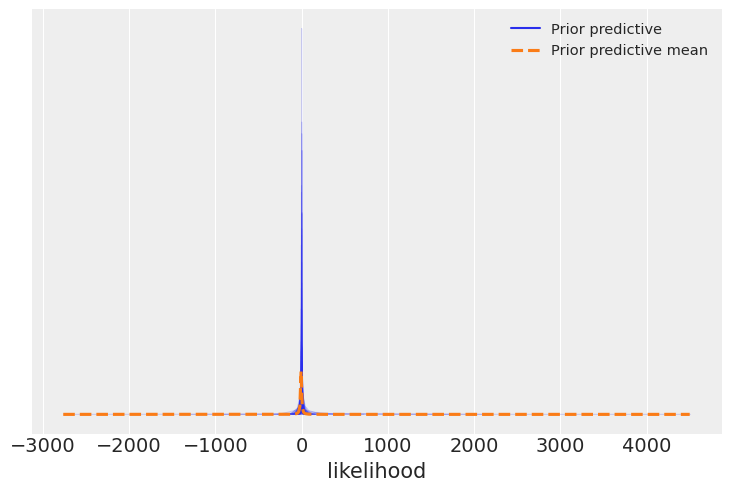

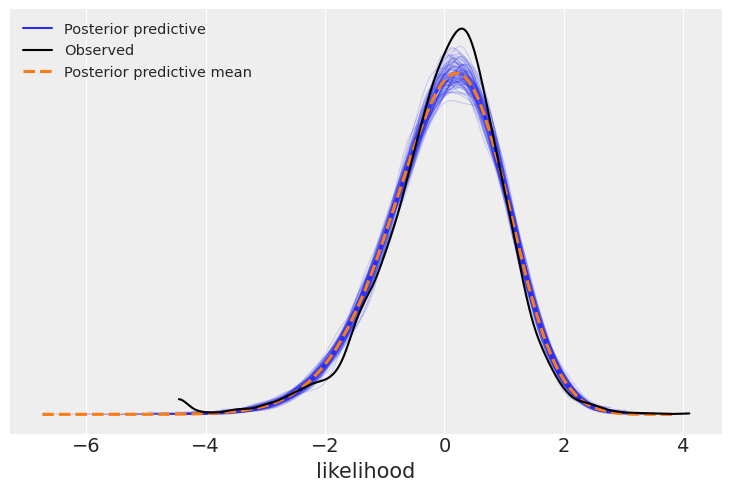

In [16]:
az.plot_ppc(
    idata,
    num_pp_samples=100,
    kind="kde",
    group="prior",
);
az.plot_ppc(
    idata,
    num_pp_samples=100,
    kind="kde",
    group="posterior",
);

# Generate traces for model comparison

In [13]:
from itertools import product

# define models
models = ["sgm"]
stimuli = df["stimulus"].unique()
measures = ["R_tot", "tau_R", "tau_double"]
areas = ["cortex"] # only need model for cortex
# areas = ["allareas", "cortex"]
combinations = list(product(areas, models, measures, stimuli))
log.info(f"{combinations=}")

# ~1h on M1 mac
for area, model_name, measure, stim, in combinations:

    if area == "allareas" and model_name == "lmm":
        # linear model needs hierarchy score values, which dont exist for thalamus.
        # for model comparison, we only use models fitted on cortex.
        continue

    log.info(f"running: {model_name} {stim} {measure} {area}")

    if area == "allareas":
        this_df = df
    elif area == "cortex":
        this_df = df.query(f"structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']")
    else:
        raise ValueError(f"unknown area: {area}")

    this_df = this_df.query(f"stimulus == '{stim}'")

    log.info(f"using df for {stim} with {len(this_df)} rows")
    if model_name == "lmm":
        model = bm.LinearMedianModel(
            this_df,
            measure,
            noncentered=True,
        )
    elif model_name == "sgm":
        model = bm.StructureGroupModel(
            this_df,
            measure,
            noncentered=True,
        )
    else:
        raise ValueError(f"unknown model: {model_name}")

    with model:
        idata = pm.sample(
            nuts_sampler="nutpie",
            draws=3000,
            tune=2000,
            random_seed=42,
            target_accept=0.95,
        )

        log.info(f"running ppc: {model_name}")
        idata.extend(pm.sample_prior_predictive(random_seed=42))
        idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=42))

        log.info(f"computing likeliehood: {model_name}")
        idata.extend(pm.compute_log_likelihood(idata))

        log.info(f"saving: {model_name}")
        idata.to_netcdf(
            f"{data_dir}/bayes_{area}_{model_name}_{measure}_{stim}.nc"
        )  # ~ 1.8GB each

2025-01-24 15:04:30,790 | INFO     | notebook | <module> | combinations=[('cortex', 'sgm', 'R_tot', 'natural_movie_three'), ('cortex', 'sgm', 'R_tot', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'R_tot', 'spontaneous'), ('cortex', 'sgm', 'tau_R', 'natural_movie_three'), ('cortex', 'sgm', 'tau_R', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_R', 'spontaneous'), ('cortex', 'sgm', 'tau_double', 'natural_movie_three'), ('cortex', 'sgm', 'tau_double', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_double', 'spontaneous')]
2025-01-24 15:04:30,790 | INFO     | notebook | <module> | running: sgm natural_movie_three R_tot cortex
2025-01-24 15:04:30,797 | INFO     | notebook | <module> | using df for natural_movie_three with 4758 rows


2025-01-24 15:04:53,255 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-24 15:04:53,315 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-24 15:04:53,540 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-24 15:04:55,573 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-24 15:04:57,738 | INFO     | notebook | <module> | saving: sgm
2025-01-24 15:05:18,770 | INFO     | notebook | <module> | running: sgm natural_movie_one_more_repeats R_tot cortex
2025-01-24 15:05:18,777 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 4554 rows


2025-01-24 15:05:37,659 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-24 15:05:37,723 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-24 15:05:37,940 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-24 15:05:39,812 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-24 15:05:41,173 | INFO     | notebook | <module> | saving: sgm
2025-01-24 15:06:01,220 | INFO     | notebook | <module> | running: sgm spontaneous R_tot cortex
2025-01-24 15:06:01,226 | INFO     | notebook | <module> | using df for spontaneous with 4594 rows


2025-01-24 15:06:18,063 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-24 15:06:18,125 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-24 15:06:18,333 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-24 15:06:20,184 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-24 15:06:21,430 | INFO     | notebook | <module> | saving: sgm
2025-01-24 15:06:41,853 | INFO     | notebook | <module> | running: sgm natural_movie_three tau_R cortex
2025-01-24 15:06:41,860 | INFO     | notebook | <module> | using df for natural_movie_three with 4758 rows


2025-01-24 15:07:30,833 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-24 15:07:30,893 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-24 15:07:31,175 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-24 15:07:34,402 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-24 15:07:37,065 | INFO     | notebook | <module> | saving: sgm
2025-01-24 15:07:57,819 | INFO     | notebook | <module> | running: sgm natural_movie_one_more_repeats tau_R cortex
2025-01-24 15:07:57,827 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 4554 rows


2025-01-24 15:08:44,217 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-24 15:08:44,276 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-24 15:08:44,546 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-24 15:08:47,668 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-24 15:08:50,149 | INFO     | notebook | <module> | saving: sgm
2025-01-24 15:09:10,034 | INFO     | notebook | <module> | running: sgm spontaneous tau_R cortex
2025-01-24 15:09:10,042 | INFO     | notebook | <module> | using df for spontaneous with 4594 rows


2025-01-24 15:10:01,654 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-24 15:10:01,713 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-24 15:10:01,981 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-24 15:10:05,142 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-24 15:10:07,811 | INFO     | notebook | <module> | saving: sgm
2025-01-24 15:10:27,802 | INFO     | notebook | <module> | running: sgm natural_movie_three tau_double cortex
2025-01-24 15:10:27,809 | INFO     | notebook | <module> | using df for natural_movie_three with 4758 rows


2025-01-24 15:11:16,444 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-24 15:11:16,503 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-24 15:11:16,779 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-24 15:11:20,049 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-24 15:11:22,703 | INFO     | notebook | <module> | saving: sgm
2025-01-24 15:11:43,676 | INFO     | notebook | <module> | running: sgm natural_movie_one_more_repeats tau_double cortex
2025-01-24 15:11:43,683 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 4554 rows


2025-01-24 15:12:31,957 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-24 15:12:32,010 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-24 15:12:32,273 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-24 15:12:35,331 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-24 15:12:37,624 | INFO     | notebook | <module> | saving: sgm
2025-01-24 15:12:57,476 | INFO     | notebook | <module> | running: sgm spontaneous tau_double cortex
2025-01-24 15:12:57,482 | INFO     | notebook | <module> | using df for spontaneous with 4594 rows


2025-01-24 15:13:57,434 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-24 15:13:57,489 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-24 15:13:57,753 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-24 15:14:01,094 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-24 15:14:03,708 | INFO     | notebook | <module> | saving: sgm


In [12]:
from itertools import product

# define models

models = ["sgm"]
stimuli = df["stimulus"].unique()
measures = ["R_tot", "tau_R", "tau_double"]
areas = ["cortex"]  # only need model for cortex
# areas = ["allareas", "cortex"]
combinations = list(product(areas, models, measures, stimuli))
log.info(f"{combinations=}")

2024-06-03 08:51:34,788 | INFO     | notebook | <module> | combinations=[('cortex', 'sgm', 'R_tot', 'natural_movie_three'), ('cortex', 'sgm', 'R_tot', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'R_tot', 'spontaneous'), ('cortex', 'sgm', 'tau_R', 'natural_movie_three'), ('cortex', 'sgm', 'tau_R', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_R', 'spontaneous'), ('cortex', 'sgm', 'tau_double', 'natural_movie_three'), ('cortex', 'sgm', 'tau_double', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_double', 'spontaneous')]


In [14]:
for area, model_name, measure, stim, in combinations:
    try:
        idata = az.from_netcdf(f"{data_dir}/bayes_{area}_{model_name}_{measure}_{stim}.nc")
    except FileNotFoundError:
        continue

    summary = az.summary(idata)
    r_hat = summary.r_hat
    num_divergences = np.sum(idata.sample_stats.diverging.values)
    print(
        f"{area} {model_name} {measure} {stim}: "
        + f"{'No divergences' if num_divergences == 0 else f'{num_divergences} divergences !!!'} "
        + (f"(r_hat: {r_hat.max():.1f})" if r_hat.max() < 1.1 else f"r_hat: {r_hat.max():.1f} !!!")
    )

cortex sgm R_tot natural_movie_three: No divergences (r_hat: 1.0)
cortex sgm R_tot natural_movie_one_more_repeats: No divergences (r_hat: 1.0)
cortex sgm R_tot spontaneous: No divergences (r_hat: 1.0)
cortex sgm tau_R natural_movie_three: No divergences (r_hat: 1.0)
cortex sgm tau_R natural_movie_one_more_repeats: No divergences (r_hat: 1.0)
cortex sgm tau_R spontaneous: No divergences (r_hat: 1.0)
cortex sgm tau_double natural_movie_three: No divergences (r_hat: 1.0)
cortex sgm tau_double natural_movie_one_more_repeats: No divergences (r_hat: 1.0)
cortex sgm tau_double spontaneous: No divergences (r_hat: 1.0)


# Reviewer Suggestion

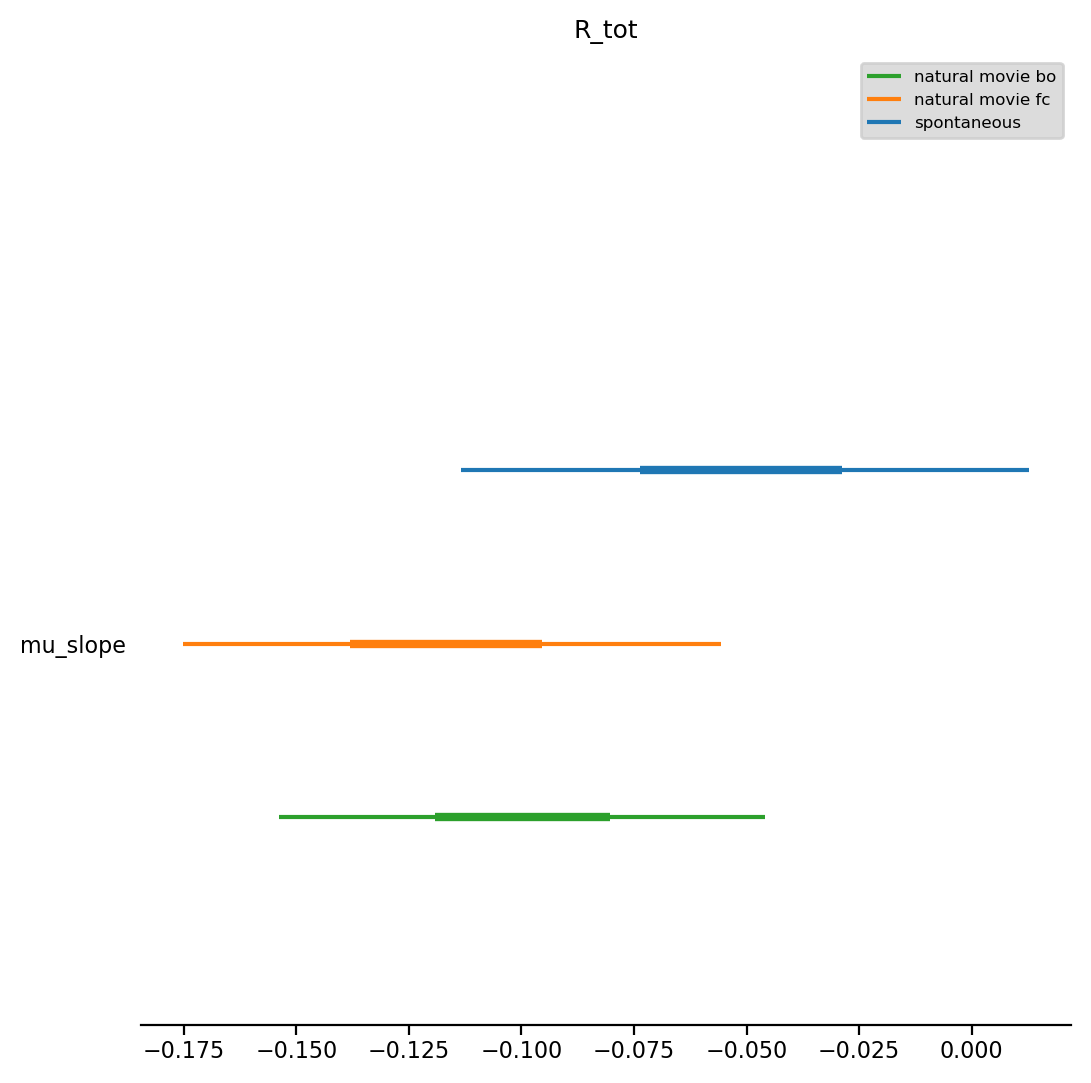

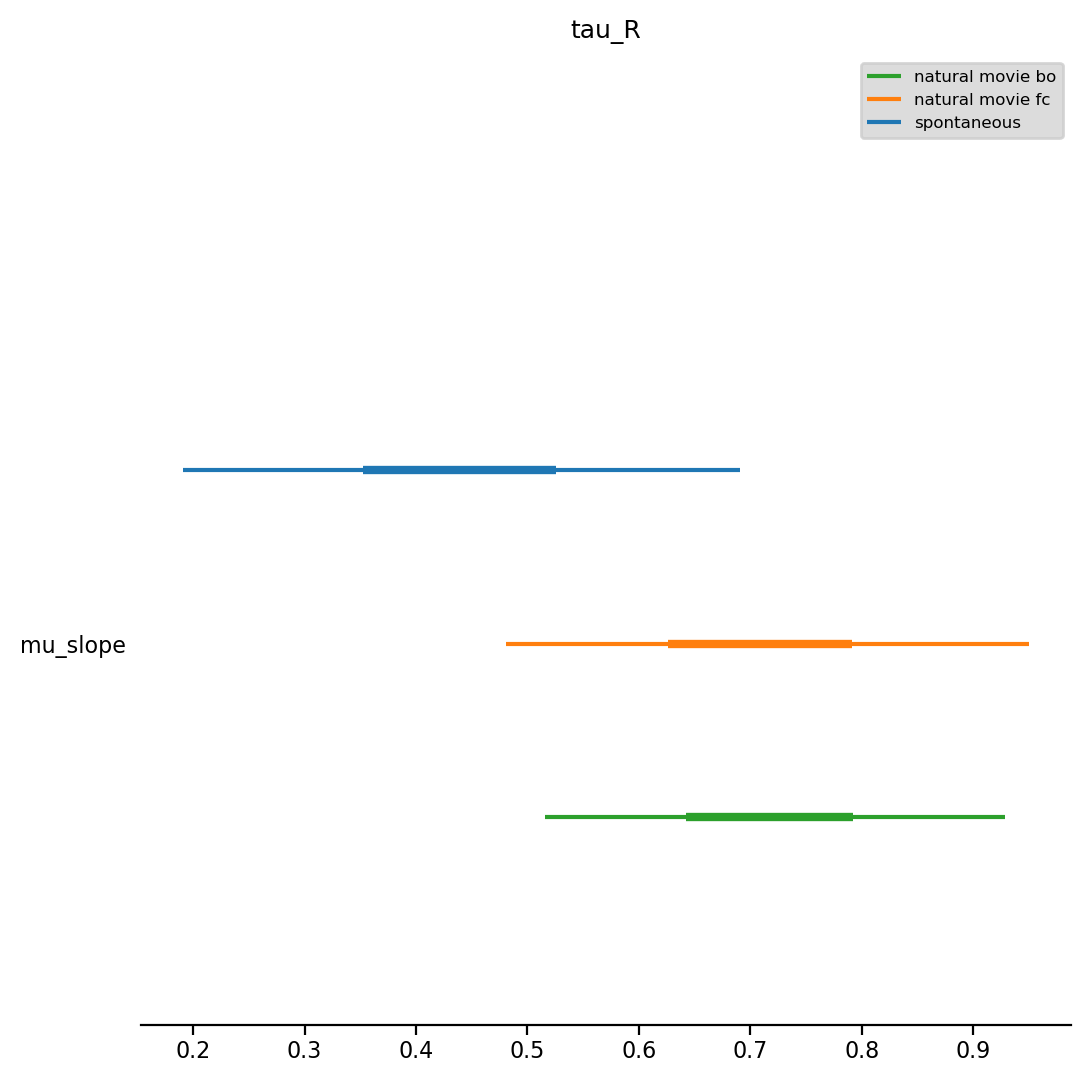

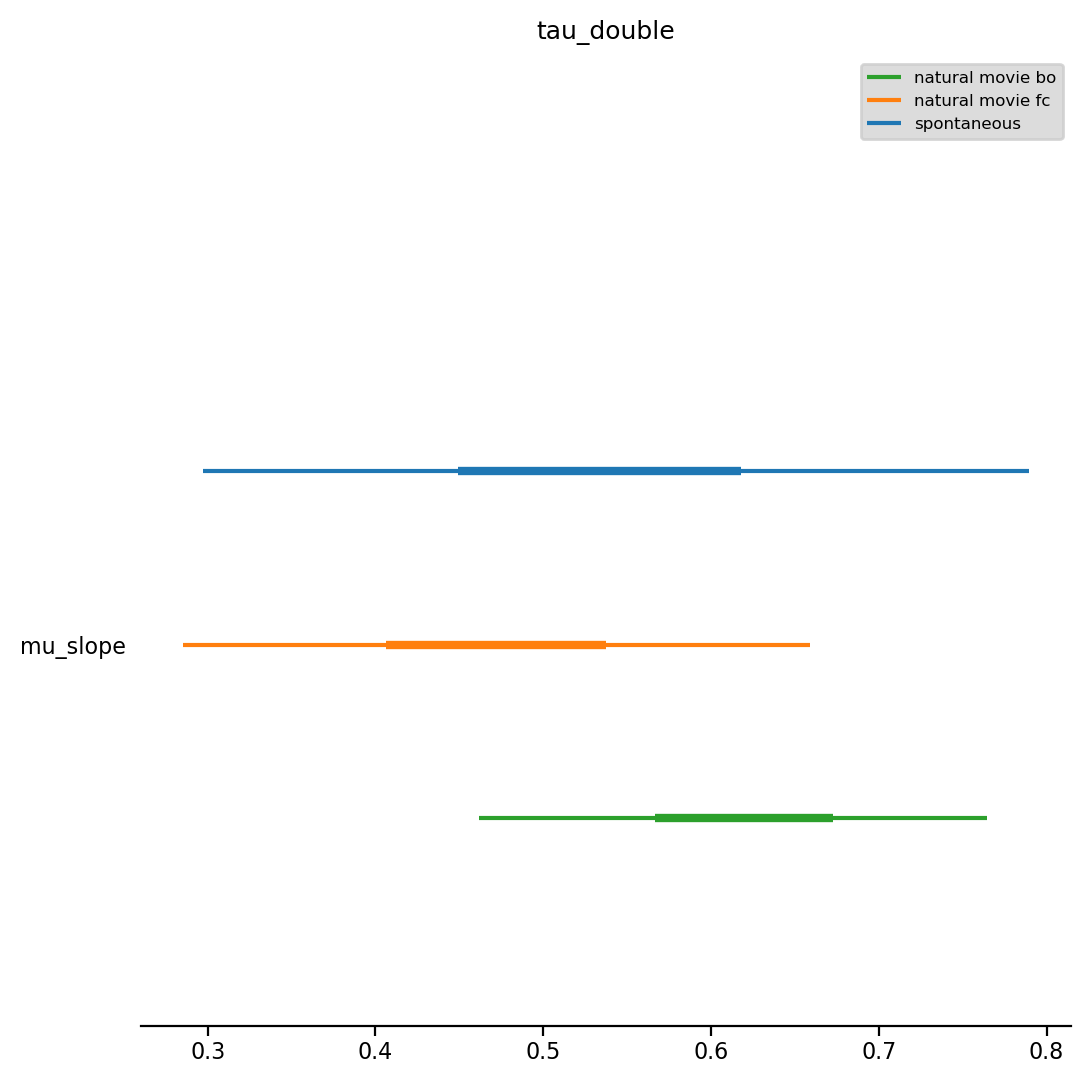

In [26]:
for obs in ["R_tot", "tau_R", "tau_double"]:
    idata_spont = az.from_netcdf(f"{data_dir}/bayes_cortex_lmm_{obs}_spontaneous.nc")
    idata_nat_mov_fc = az.from_netcdf(f"{data_dir}/bayes_cortex_lmm_{obs}_natural_movie_one_more_repeats.nc")
    idata_nat_mov_bo = az.from_netcdf(f"{data_dir}/bayes_cortex_lmm_{obs}_natural_movie_three.nc")
    ax = az.plot_forest(
        [
            idata_spont,
            idata_nat_mov_fc,
            idata_nat_mov_bo,
        ],
        model_names=["spontaneous",  "natural movie fc", "natural movie bo"],
        var_names=["mu_slope"],
        combined=True, # combines chains
        combine_dims=set(["draw", "session"]),
    )
    ax[0].set_title(obs)

In [12]:
%load_ext watermark
%watermark -v --iversions --packages nutpie,pymc,arviz

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

nutpie: 0.10.0
pymc  : 5.14.0
arviz : 0.18.0

numpy         : 1.24.4
sys           : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
pandas        : 2.0.3
arviz         : 0.18.0
IPython       : 8.22.2
nutpie        : 0.10.0
sqlite3       : 2.6.0
logging       : 0.5.1.2
pymc          : 5.14.0
prompt_toolkit: 3.0.42

